In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance

In [2]:
def classification_metrics(y_true, y_pred, label="",
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict
    
    
    
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict
from sklearn import set_config
set_config(transform_output= 'pandas')

In [3]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def regression_metrics(y_true, y_pred, label='', verbose = True, output_dict=False):
  # Get metrics
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = mean_squared_error(y_true, y_pred, squared=False) 
  r_squared = r2_score(y_true, y_pred)
  if verbose == True:
    # Print Result with Label and Header
    header = "-"*60
    print(header, f"Regression Metrics: {label}", header, sep='\n')
    print(f"- MAE = {mae:,.3f}")
    print(f"- MSE = {mse:,.3f}")
    print(f"- RMSE = {rmse:,.3f}")
    print(f"- R^2 = {r_squared:,.3f}")
  if output_dict == True:
      metrics = {'Label':label, 'MAE':mae,
                 'MSE':mse, 'RMSE':rmse, 'R^2':r_squared}
      return metrics

def evaluate_regression(reg, X_train, y_train, X_test, y_test, verbose = True,
                        output_frame=False):
  # Get predictions for training data
  y_train_pred = reg.predict(X_train)
 
  # Call the helper function to obtain regression metrics for training data
  results_train = regression_metrics(y_train, y_train_pred, verbose = verbose,
                                     output_dict=output_frame,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = reg.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = regression_metrics(y_test, y_test_pred, verbose = verbose,
                                  output_dict=output_frame,
                                    label='Test Data' )
  
  # Store results in a dataframe if ouput_frame is True
  if output_frame:
    results_df = pd.DataFrame([results_train,results_test])
    # Set the label as the index 
    results_df = results_df.set_index('Label')
    # Set index.name to none to get a cleaner looking result
    results_df.index.name=None
    # Return the dataframe
    return results_df.round(3)

In [4]:
df= pd.read_csv('Data/cirrhosis.csv')
df.head()

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


In [5]:
df.isna().sum()

ID                 0
N_Days             0
Status             0
Drug             106
Age                0
Sex                0
Ascites          106
Hepatomegaly     106
Spiders          106
Edema              0
Bilirubin          0
Cholesterol      134
Albumin            0
Copper           108
Alk_Phos         106
SGOT             106
Tryglicerides    136
Platelets         11
Prothrombin        2
Stage              6
dtype: int64

In [6]:
df['Age']= df['Age']/365
df

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,D,D-penicillamine,58.805479,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,C,D-penicillamine,56.484932,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,D,D-penicillamine,70.120548,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,D,D-penicillamine,54.778082,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5,1504,CL,Placebo,38.131507,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,414,681,D,NaN,67.046575,F,NaN,NaN,NaN,N,1.2,NaN,2.96,NaN,NaN,NaN,NaN,174.0,10.9,3.0
414,415,1103,C,NaN,39.027397,F,NaN,NaN,NaN,N,0.9,NaN,3.83,NaN,NaN,NaN,NaN,180.0,11.2,4.0
415,416,1055,C,NaN,57.038356,F,NaN,NaN,NaN,N,1.6,NaN,3.42,NaN,NaN,NaN,NaN,143.0,9.9,3.0
416,417,691,C,NaN,58.041096,F,NaN,NaN,NaN,N,0.8,NaN,3.75,NaN,NaN,NaN,NaN,269.0,10.4,3.0


In [7]:
# PREPROCESSING

target='Status'

drop_cols= ['ID']

X = df.drop(columns=[target] + drop_cols)
y= df[target].copy()

X_train,X_test,y_train,y_test = train_test_split(X,y, random_state=42)

In [8]:
# Preprocessing

num_cols = X_train.select_dtypes(include=['number']).columns
cat_cols = X_train.select_dtypes(include=['object']).columns

imputer = SimpleImputer(strategy='constant')

scaler = StandardScaler()

ohe_encoder = OneHotEncoder(sparse=False)

num_pipe= make_pipeline(imputer)

cat_pipe= make_pipeline(imputer, ohe_encoder)

In [9]:
num_tuple = ('numeric', num_pipe, num_cols)
num_tuple

('numeric',
 Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='constant'))]),
 Index(['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
        'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
        'Stage'],
       dtype='object'))

In [10]:
cat_tuple= ('categorical', cat_pipe, cat_cols)

In [11]:
transformer = ColumnTransformer([num_tuple, cat_tuple],
                                    verbose_feature_names_out=False)
transformer

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='constant'))]),
                                 Index(['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
       'Stage'],
      dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(sparse=False))]),
                                 Index(['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema'], dtype='object'))],
                  verbose_feature_names_out=False)

In [12]:
transformer.fit(X_train)
feature_names = transformer.get_feature_names_out()
feature_names

/Users/sofiawang/anaconda3/envs/dojo-env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array(['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
       'Stage', 'Drug_D-penicillamine', 'Drug_Placebo',
       'Drug_missing_value', 'Sex_F', 'Sex_M', 'Ascites_N', 'Ascites_Y',
       'Ascites_missing_value', 'Hepatomegaly_N', 'Hepatomegaly_Y',
       'Hepatomegaly_missing_value', 'Spiders_N', 'Spiders_Y',
       'Spiders_missing_value', 'Edema_N', 'Edema_S', 'Edema_Y'],
      dtype=object)

In [13]:
X_train_processed = transformer.transform(X_train)

X_test_processed = transformer.transform(X_test)

X_train_processed.head()

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,...,Ascites_missing_value,Hepatomegaly_N,Hepatomegaly_Y,Hepatomegaly_missing_value,Spiders_N,Spiders_Y,Spiders_missing_value,Edema_N,Edema_S,Edema_Y
132,2796.0,62.687671,1.5,331.0,3.95,13.0,577.0,128.65,99.0,165.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
60,4256.0,43.928767,0.6,216.0,3.94,28.0,601.0,60.45,188.0,211.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
198,1592.0,40.745205,2.1,392.0,3.43,52.0,1395.0,184.45,194.0,328.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
332,1518.0,56.038356,2.8,0.0,3.92,0.0,0.0,0.00,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
63,1487.0,62.950685,2.1,373.0,3.50,52.0,1009.0,150.35,188.0,178.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [14]:
X_train_tf = pd.DataFrame(transformer.transform(X_train),
                           columns = feature_names, index = X_train.index)
X_train_tf.head()

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,...,Ascites_missing_value,Hepatomegaly_N,Hepatomegaly_Y,Hepatomegaly_missing_value,Spiders_N,Spiders_Y,Spiders_missing_value,Edema_N,Edema_S,Edema_Y
132,2796.0,62.687671,1.5,331.0,3.95,13.0,577.0,128.65,99.0,165.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
60,4256.0,43.928767,0.6,216.0,3.94,28.0,601.0,60.45,188.0,211.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
198,1592.0,40.745205,2.1,392.0,3.43,52.0,1395.0,184.45,194.0,328.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
332,1518.0,56.038356,2.8,0.0,3.92,0.0,0.0,0.00,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
63,1487.0,62.950685,2.1,373.0,3.50,52.0,1009.0,150.35,188.0,178.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [15]:
X_test_tf = pd.DataFrame(transformer.transform(X_test),
                           columns = feature_names, index = X_test.index)
X_test_tf.head()

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,...,Ascites_missing_value,Hepatomegaly_N,Hepatomegaly_Y,Hepatomegaly_missing_value,Spiders_N,Spiders_Y,Spiders_missing_value,Edema_N,Edema_S,Edema_Y
321,2011.0,64.043836,1.1,0.0,3.69,0.0,0.0,0.00,0.0,139.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
324,4795.0,34.024658,1.8,0.0,3.24,0.0,0.0,0.00,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
388,1581.0,67.046575,0.7,0.0,3.06,0.0,0.0,0.00,0.0,165.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
56,3282.0,53.608219,2.3,260.0,3.18,231.0,11320.2,105.78,94.0,216.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
153,140.0,69.424658,2.4,168.0,2.56,225.0,1056.0,120.90,75.0,108.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [16]:
reg = RandomForestRegressor(random_state=42)

label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train)

reg.fit(X_train_processed, y_train_encoded)

RandomForestRegressor(random_state=42)

In [17]:
importances = pd.Series(reg.feature_importances_, index= feature_names,
                       name='Feature Importance')

importances_sorted = importances.sort_values(ascending=False)
importances_sorted.head(10)

N_Days         0.264386
Bilirubin      0.226174
Alk_Phos       0.082233
Prothrombin    0.078716
Age            0.073486
Platelets      0.057311
Albumin        0.042417
Copper         0.033595
SGOT           0.032856
Cholesterol    0.022265
Name: Feature Importance, dtype: float64

**Do these features make sense based on the business case?**

These features make sense because they would play a role in determining the status of the patient.

Text(0.5, 1.0, 'Days of Treatment and Patient Status')

<Figure size 1200x600 with 0 Axes>

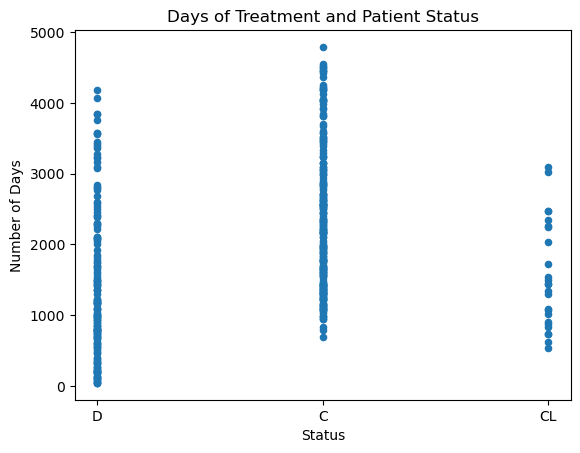

In [28]:
# Feature 1 Viz
plt.figure(figsize=(12, 6))

df.plot.scatter(x='Status', y='N_Days')

plt.xlabel('Status')
plt.ylabel('Number of Days')
plt.title(f'Days of Treatment and Patient Status')

**Visualization 1 Explanation** 

With this scatter plot we can see the different stages patients are in and their varying time on the treatment. This is valuable information because it shows us that patients can be at varying stages despite undegoing the same treatment with the same amount of time. These things could be attributed to the stage of cirrhosis they are in and the way their body reacts to the treatment. 

Text(0.5, 1.0, 'Bilirubin (mg) and its Effect of Patient Status')

<Figure size 1200x600 with 0 Axes>

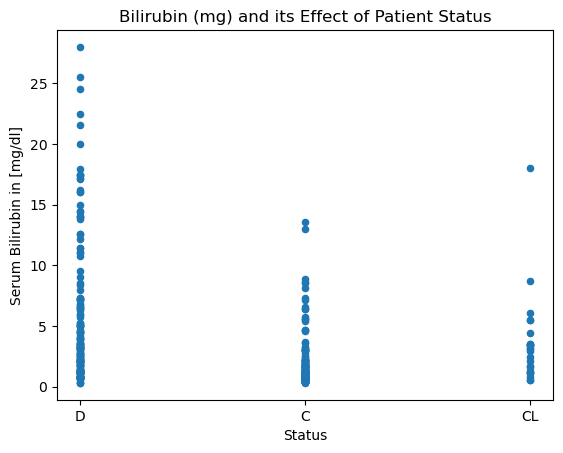

In [29]:
# Feature 2 Viz
plt.figure(figsize=(12, 6))

df.plot.scatter(x='Status', y='Bilirubin')

plt.xlabel('Status')
plt.ylabel('Serum Bilirubin in [mg/dl]')
plt.title(f'Bilirubin (mg) and its Effect of Patient Status')

**Visualization 2 Explanation**

From this chart we can see that the patients with higher levels of Bilirubin fall mostly in the D status. This visualization is useful for determining the effect of Serum Bilirubin. 